In [37]:
# Import libraries
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Data Processing

In [217]:
# Read in the trip summary data
trips_file_path = '../data/trip_summary_201901.csv'
weather_file_path = '../data/hourly_weather_201901.csv'

trips = pd.read_csv(trips_file_path).dropna()
weather = pd.read_csv(weather_file_path).dropna()

print(len(trips))
print(trips['start_station_id'].nunique())
print(trips.head(), '\n')

print(len(weather))
print(weather.head())

124502
152
   start_date  start_hour  start_station_id               start_station_name  \
0  2019-01-01           0               109           17th St at Valencia St   
1  2019-01-01           0               109           17th St at Valencia St   
2  2019-01-01           0               118  Eureka Valley Recreation Center   
3  2019-01-01           0               119                18th St at Noe St   
4  2019-01-01           0               120             Mission Dolores Park   

   start_station_cap start_station_has_kiosk  end_station_id  \
0               23.0                    True             141   
1               23.0                    True              91   
2               19.0                    True             126   
3               15.0                    True              98   
4               27.0                    True              98   

                 end_station_name  end_station_cap end_station_has_kiosk  \
0  Valencia St at Cesar Chavez St             1

In [218]:
# Data quality checks
print('Number of NaNs in the trips df:\n', trips.isnull().sum(), '\n')
print('Number of NaNs in the weather df:\n', weather.isnull().sum(), '\n')

print(trips.describe())

Number of NaNs in the trips df:
 start_date                 0
start_hour                 0
start_station_id           0
start_station_name         0
start_station_cap          0
start_station_has_kiosk    0
end_station_id             0
end_station_name           0
end_station_cap            0
end_station_has_kiosk      0
start_station_latitude     0
start_station_longitude    0
end_station_latitude       0
end_station_longitude      0
sum_duration_sec           0
sum_duration_min           0
trip_count                 0
subscriber_trip_count      0
customer_trip_count        0
dtype: int64 

Number of NaNs in the weather df:
 start_date       0
start_hour       0
datetime_hour    0
datetime_mod     0
temperature      0
wind             0
precip_          0
dtype: int64 

          start_hour  start_station_id  start_station_cap  end_station_id  \
count  124502.000000     124502.000000      124502.000000   124502.000000   
mean       13.377544        103.183258          26.336035      1

In [219]:
# Feature engineering

# Merge trips and weather
trips = pd.merge(trips, weather, on=['start_date', 'start_hour'], how='inner')

trips['start_station_has_kiosk'] = trips['start_station_has_kiosk'].astype('bool')
trips['end_station_has_kiosk'] = trips['end_station_has_kiosk'].astype('bool')
trips['start_dow'] = trips['start_date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d')).dt.weekday_name
trips['temperature'] = trips['temperature'].str.split(" ", expand = True)[0].astype('float')
trips['wind'] = trips['wind'].str.split(" ", expand = True)[0].astype('float')
trips['precip_'] = trips['precip_'].str.split(" ", expand = True)[0].astype('float')

print(len(trips))
print(trips.dtypes)
trips.head()

124502
start_date                  object
start_hour                   int64
start_station_id             int64
start_station_name          object
start_station_cap          float64
start_station_has_kiosk       bool
end_station_id               int64
end_station_name            object
end_station_cap            float64
end_station_has_kiosk         bool
start_station_latitude     float64
start_station_longitude    float64
end_station_latitude       float64
end_station_longitude      float64
sum_duration_sec             int64
sum_duration_min           float64
trip_count                   int64
subscriber_trip_count        int64
customer_trip_count          int64
datetime_hour               object
datetime_mod                object
temperature                float64
wind                       float64
precip_                    float64
start_dow                   object
dtype: object


,start_date,start_hour,start_station_id,start_station_name,start_station_cap,start_station_has_kiosk,end_station_id,end_station_name,end_station_cap,end_station_has_kiosk,...,sum_duration_min,trip_count,subscriber_trip_count,customer_trip_count,datetime_hour,datetime_mod,temperature,wind,precip_,start_dow
0,2019-01-01,0,109,17th St at Valencia St,23.0,True,141,Valencia St at Cesar Chavez St,19.0,True,...,6.500000,1,1,0,2019-01-01 00:00:00 UTC,2019-01-01 00:56:00 UTC,47.0,12.0,0.0,Tuesday
1,2019-01-01,0,109,17th St at Valencia St,23.0,True,91,Berry St at King St,23.0,True,...,13.000000,1,1,0,2019-01-01 00:00:00 UTC,2019-01-01 00:56:00 UTC,47.0,12.0,0.0,Tuesday
2,2019-01-01,0,118,Eureka Valley Recreation Center,19.0,True,126,Esprit Park,31.0,True,...,21.766667,1,1,0,2019-01-01 00:00:00 UTC,2019-01-01 00:56:00 UTC,47.0,12.0,0.0,Tuesday
3,2019-01-01,0,119,18th St at Noe St,15.0,True,98,Valencia St at 16th St,23.0,True,...,7.033333,1,1,0,2019-01-01 00:00:00 UTC,2019-01-01 00:56:00 UTC,47.0,12.0,0.0,Tuesday
4,2019-01-01,0,120,Mission Dolores Park,27.0,True,98,Valencia St at 16th St,23.0,True,...,4.616667,1,1,0,2019-01-01 00:00:00 UTC,2019-01-01 00:56:00 UTC,47.0,12.0,0.0,Tuesday


In [286]:
# Split data into training and test set
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

X = trips[['start_date'
           , 'start_hour'
           , 'start_station_cap'
           , 'start_station_has_kiosk'
           , 'end_station_cap'
           , 'end_station_has_kiosk'
           , 'start_station_latitude'
           , 'start_station_longitude'
           , 'end_station_latitude'
           , 'end_station_longitude'
           , 'temperature'
           , 'wind'
           , 'precip_'
#            , 'start_station_id'
#            , 'end_station_id'
           , 'start_dow']]
y = trips['trip_count']

# onehot_cols = ['start_station_id', 'end_station_id', 'start_dow']
onehot_cols = ['start_dow']

for k, v in enumerate(onehot_cols):
    one_hot = pd.get_dummies(X[v], prefix=v)
    X = X.drop(v, axis=1) # drop column as it is now encoded
    X = pd.concat([X, one_hot], axis=1) # concat the encoded dataframe to original

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
X_test = X_test[X_test.columns.difference(['start_date'])]

print('Number of samples in training data:', len(X_train))
print('Number of samples in test data:', len(X_test))

(124502, 20)
(124502,)
Number of samples in training data: 99601
Number of samples in test data: 24901


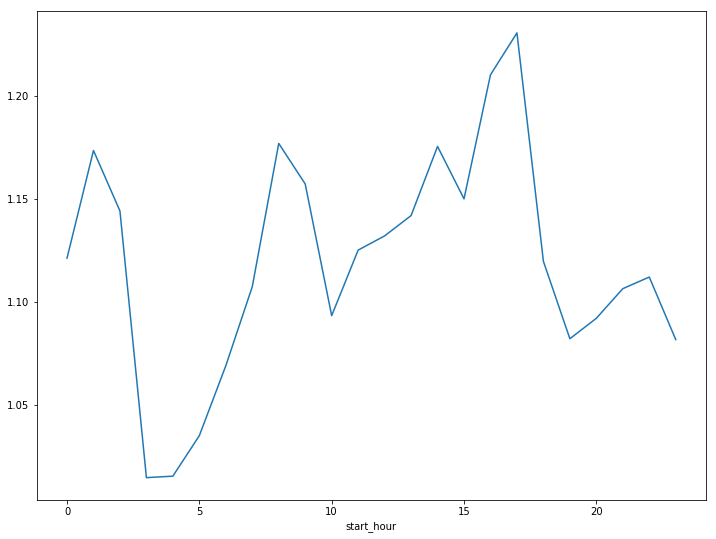

In [287]:
# Quick check: Plot trip counts by start_hour to check if timezone is correct

# To print pyplot output inline in the notebook withput calling plt.show()
%matplotlib inline

# Increase standard plot size
plt.rcParams['figure.figsize'] = (12, 9)

trips_train = X_train.join(y_train)

# Calculate and plot average trip_count grouped by start_hour
trips_by_hour = trips_train.groupby('start_hour')['trip_count'].mean()
trips_by_hour.plot()

# Comment: we can see that the peaks in activity happen in the morning and late afternoon.
# This indicates that the timezone of the datetimes are in PST.

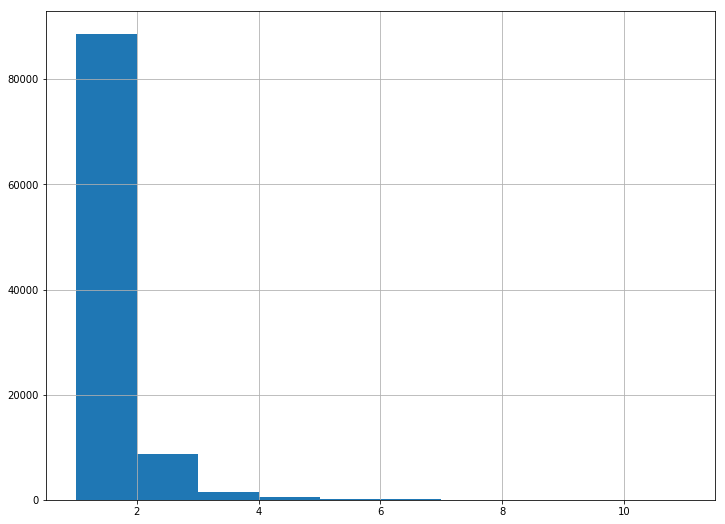

In [288]:
# Plot the distribution of the response var to check imbalance
y_train.hist()

# Comment: there is a huge imbalance towards trip_count = 1 compared to other values.
# The model may not learn the features of other responses properly.

In [289]:
# Handle imbalanced data
from sklearn.utils import resample

# Exclude last day of Jan <- saved for prediction task later
trips_imb = trips_train[trips_train['start_date'] != '2019-01-31']
trips_bal = trips_imb

# # Separate majority and minority classes
# trips_maj = trips_imb[trips_imb['trip_count'] == 1]

# # Downsample majority class
# trips_maj_down = resample(trips_maj, n_samples=int(len(trips_maj)/2), random_state=100)

# for iter in sorted(trips_imb[trips_imb['trip_count'] != 1]['trip_count'].unique()):
#     trips_min = trips_imb[trips_imb['trip_count'] == iter]
    
#     # Upsample minority class
#     trips_min_up = resample(trips_min, replace=True, n_samples=int(len(trips_min)*2), random_state=100)

#     # Combine majority class with upsampled minority class
#     trips_maj_down = pd.concat([trips_maj_down, trips_min_up])

# trips_bal = trips_maj_down

# Display new class counts
print(trips_bal['trip_count'].value_counts())

# Re-define training datasets
X_train = trips_bal[trips_bal.columns.difference(['start_date', 'trip_count'])]
y_train = trips_bal['trip_count']

print(X_train.shape)
print(y_train.shape)

1     84507
2      8261
3      1375
4       509
5       168
6        81
7        33
8        13
9         8
11        3
10        2
Name: trip_count, dtype: int64
(94960, 19)
(94960,)


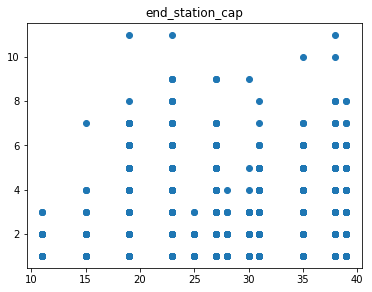

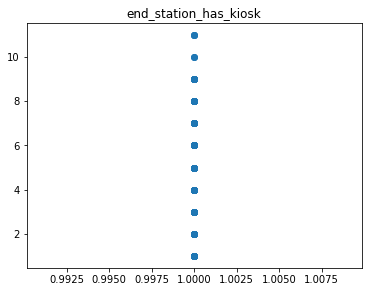

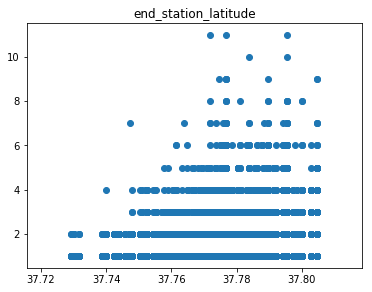

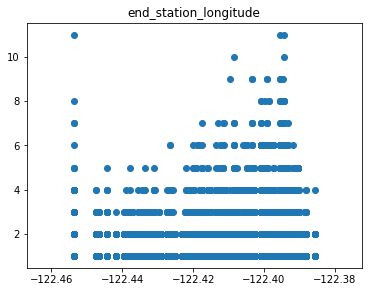

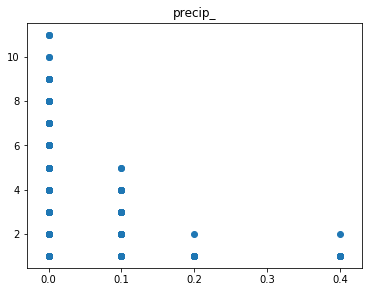

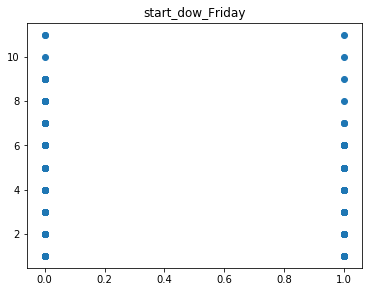

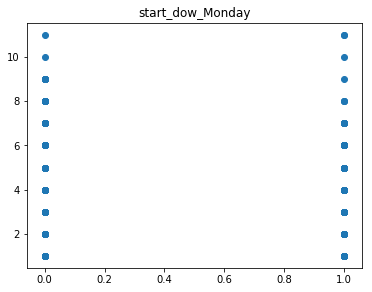

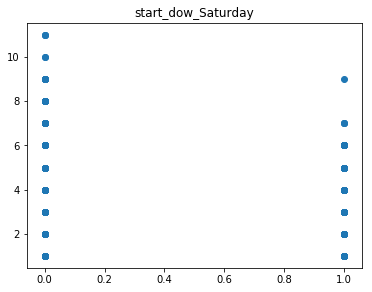

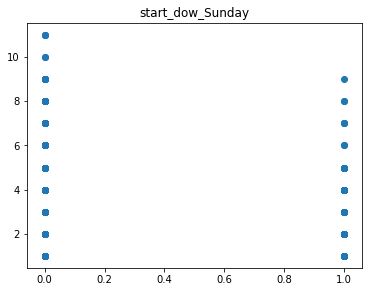

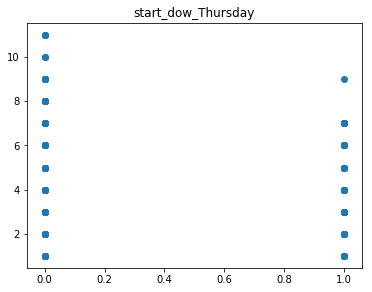

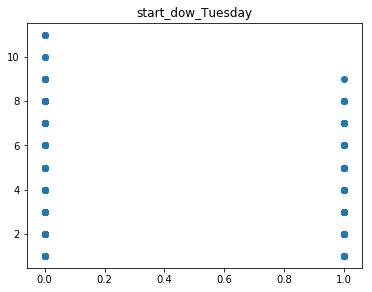

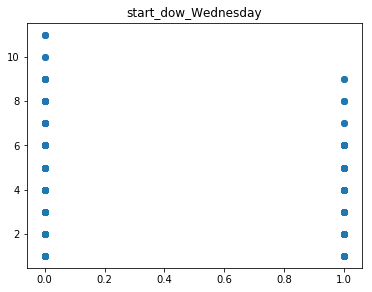

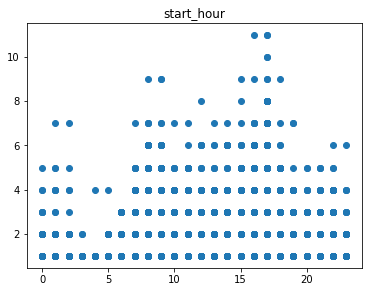

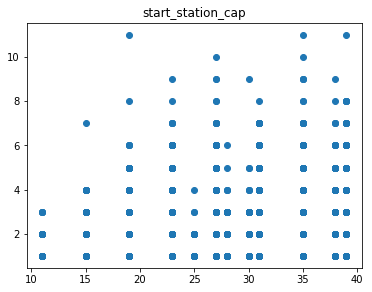

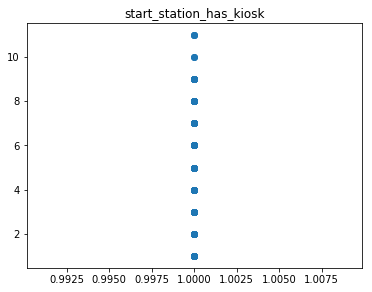

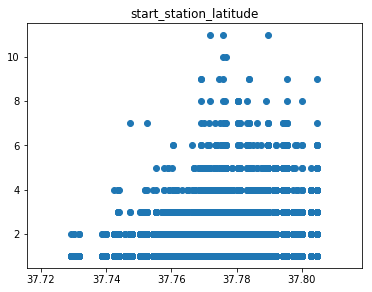

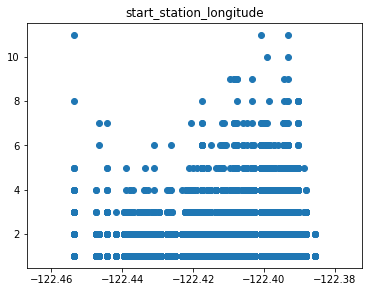

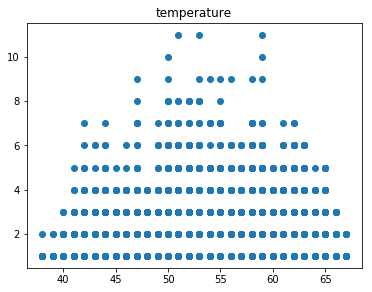

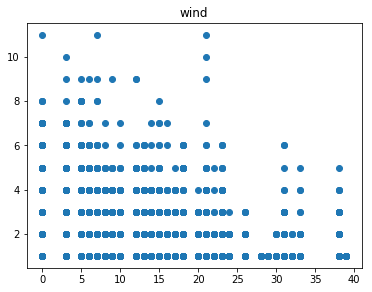

<Figure size 432x324 with 0 Axes>

In [290]:
# Plot response vs. input features
plt.rcParams['figure.figsize'] = (6, 4.5)

for col in X_train.columns:
    plt.scatter(X_train[col], y_train)
    plt.title(col)
    plt.figure()

In [291]:
# Normalize the features and generate polynomial features
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures

X_scaler = preprocessing.StandardScaler().fit(X_train)
print(X_scaler.mean_)
print(X_scaler.scale_)

X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)
print(X_train_norm.shape)
print(X_test_norm.shape)

# polynomial_features = PolynomialFeatures(degree=2, interaction_only=True)
# X_train_poly = polynomial_features.fit_transform(X_train_norm)
# X_test_poly = polynomial_features.fit_transform(X_test_norm)
# print(X_train_poly.shape)
# print(X_test_poly.shape)

# y_train = np.log(y_train)
# y_test = np.log(y_test)

[ 2.64699031e+01  1.00000000e+00  3.77769096e+01 -1.22407424e+02
  2.15143218e-03  1.61973463e-01  1.57540017e-01  8.46566976e-02
  6.01305813e-02  1.62679023e-01  1.71882898e-01  2.01137321e-01
  1.33673547e+01  2.63187447e+01  1.00000000e+00  3.77765951e+01
 -1.22408242e+02  5.49355623e+01  6.57270430e+00]
[6.35280652 1.         0.0128819  0.01343158 0.01603967 0.36842646
 0.36430915 0.27837015 0.23772862 0.36907257 0.37727863 0.40085047
 4.80538609 6.29567241 1.         0.01290794 0.01399642 5.16353529
 6.76088785]
(94960, 19)
(24901, 19)


# Model Building

RMSE: 0.516544
Train Score:  0.015333614849490584
Test Score:  0.018284643883180962


Text(0, 0.5, 'Predictions')

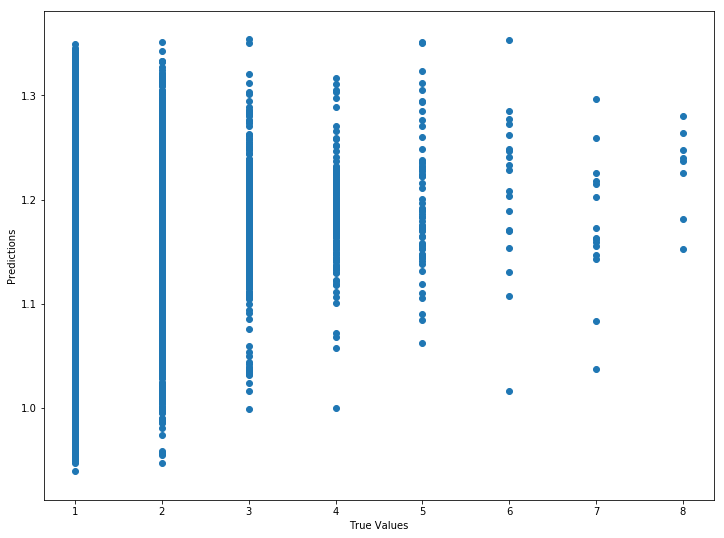

In [292]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, explained_variance_score

# Create LR model and fit the training data
lr = LinearRegression()
lr.fit(X_train_norm, y_train)

# Make prediction
y_pred_lr = lr.predict(X_test_norm)

# Print model performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("RMSE: %f" % (rmse))
print('Train Score: ', lr.score(X_train_norm, y_train))
print('Test Score: ', lr.score(X_test_norm, y_test))

# print(lr.coef_)
# print(lr.intercept_)

# Plot prediction vs. actual
plt.rcParams['figure.figsize'] = (12, 9)
plt.scatter(y_test, y_pred_lr)
plt.xlabel('True Values')
plt.ylabel('Predictions')

RMSE: 0.516547
Train Score:  0.015335578437127963
Test Score:  0.018275884040360624


Text(0, 0.5, 'Predictions')

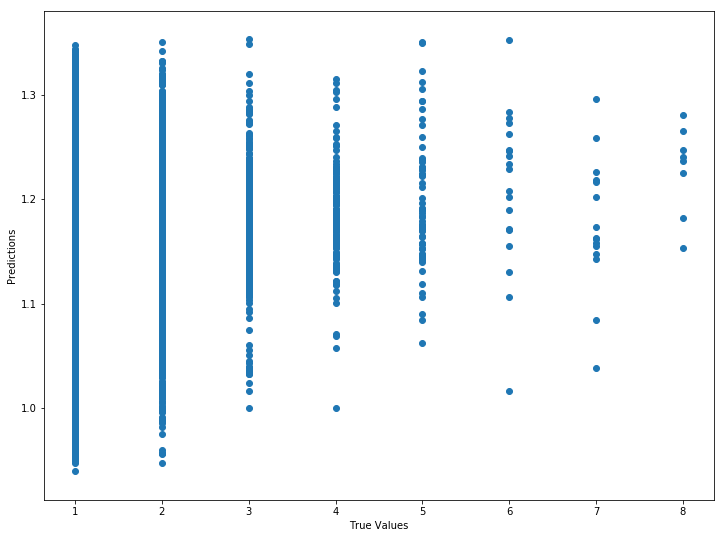

In [293]:
# Linear Regression with Regularization (Ridge)
from sklearn.linear_model import Ridge

# Create RR model and fit the training data
rr = Ridge(alpha=1.0)
rr.fit(X_train_norm, y_train)

# Make prediction
y_pred_rr = rr.predict(X_test_norm)

# Print model performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rr))
print("RMSE: %f" % (rmse))
print('Train Score: ', rr.score(X_train_norm, y_train))
print('Test Score: ', rr.score(X_test_norm, y_test))

# print(rr.coef_)
# print(rr.intercept_)

# Plot prediction vs. actual
plt.rcParams['figure.figsize'] = (12, 9)
plt.scatter(y_test, y_pred_rr)
plt.xlabel('True Values')
plt.ylabel('Predictions')

RMSE: 0.508639
Train Score:  0.04289020355384676
Test Score:  0.04810456608057778


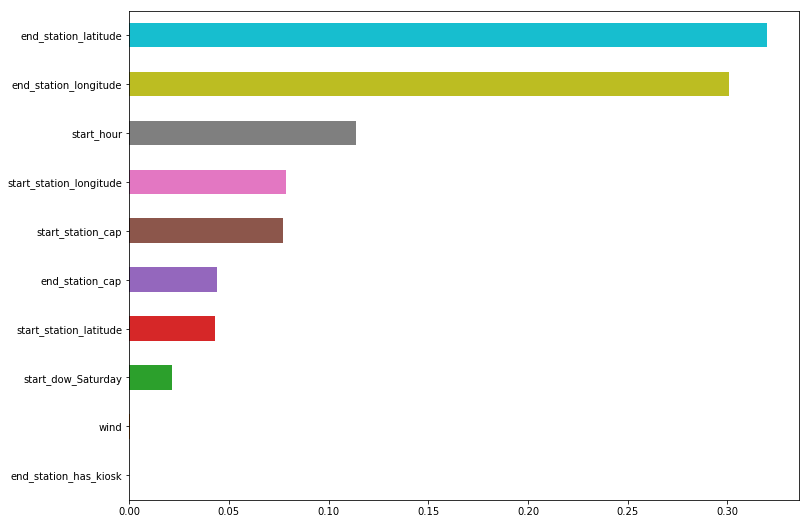

In [294]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Create RF regressor and fit the training data
rf = RandomForestRegressor(max_depth=3, n_estimators=100, random_state=100)
rf.fit(X_train_norm, y_train)

# Make prediction
y_pred_rf = rf.predict(X_test_norm)

# Print model performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print("RMSE: %f" % (rmse))
print('Train Score: ', rf.score(X_train_norm, y_train))
print('Test Score: ', rf.score(X_test_norm, y_test))

# Display feature importance
plt.rcParams['figure.figsize'] = (12, 9)
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances
feat_importances.nlargest(10).sort_values(axis=0, ascending=True).plot(kind='barh')

Text(0, 0.5, 'Predictions')

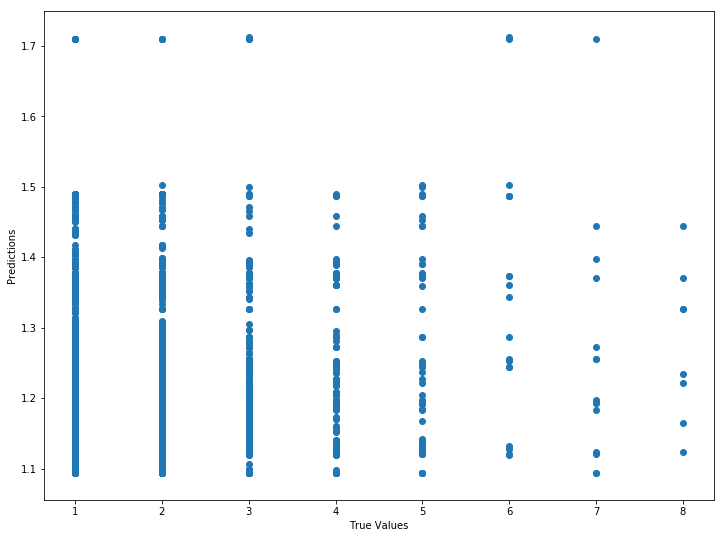

In [295]:
# Plot prediction vs. actual
plt.scatter(y_test, y_pred_rf)
plt.xlabel('True Values')
plt.ylabel('Predictions')

RMSE: 0.495205
Train Score:  0.08949772431622016
Test Score:  0.09772307756179865


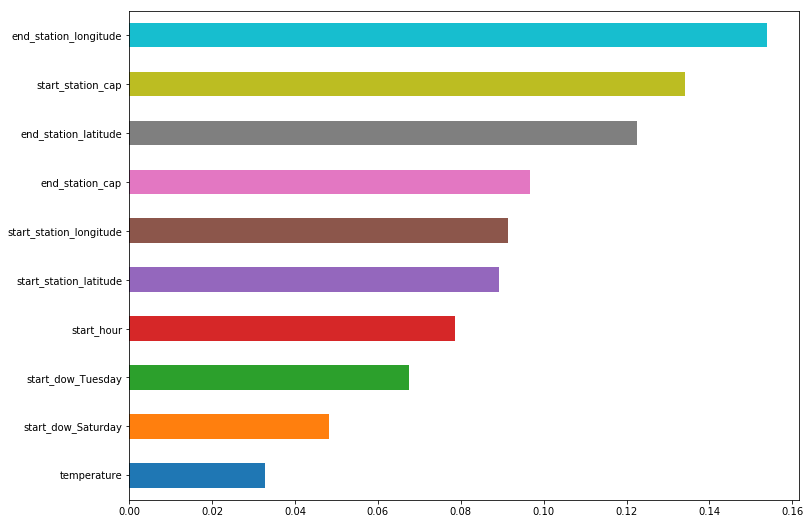

In [296]:
# XGBoost Regressor
import xgboost as xgb

# Create XGB regressor and fit the training data
xg = xgb.XGBRegressor(learning_rate=0.1, max_depth=3, n_estimators=100)
xg.fit(X_train_norm, y_train)

# Make prediction
y_pred_xg = xg.predict(X_test_norm)

# Print model performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xg))
print("RMSE: %f" % (rmse))
print('Train Score: ', xg.score(X_train_norm, y_train))
print('Test Score: ', xg.score(X_test_norm, y_test))

# Display feature importance
plt.rcParams['figure.figsize'] = (12, 9)
feat_importances = pd.Series(xg.feature_importances_, index=X_train.columns)
feat_importances
feat_importances.nlargest(10).sort_values(axis=0, ascending=True).plot(kind='barh')

# xgb.plot_importance(xg, max_num_features=10)

Text(0, 0.5, 'Predictions')

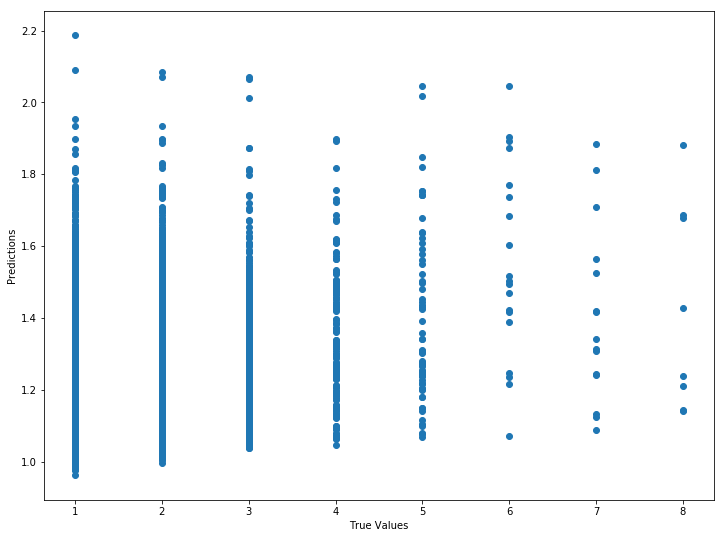

In [297]:
# Plot prediction vs. actual
plt.scatter(y_test, y_pred_xg)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [171]:
# K-fold cross-validation
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# Perform 5-fold cross validation
k = 5

scores = cross_val_score(rf, X_train, y_train, cv=k)
print('Cross-validated scores: ', scores)

Cross-validated scores:  [0.21711772 0.21320101 0.22361994 0.21347333 0.20281285]


In [309]:
# Make prediction on the last day of Jan
trips_1d = trips
# onehot_cols = ['start_station_id', 'end_station_id', 'start_dow']
onehot_cols = ['start_dow']

for k, v in enumerate(onehot_cols):
    one_hot = pd.get_dummies(trips_1d[v], prefix=v)
    trips_1d = trips_1d.drop(v, axis=1) # drop column as it is now encoded
    trips_1d = pd.concat([trips_1d, one_hot], axis=1) # join the encoded df

trips_1d = trips_1d[trips_1d['start_date'] == '2019-01-31']
X_1d = trips_1d[trips_1d.columns.difference(['start_date'
                                             , 'start_station_id', 'end_station_id'
                                             , 'start_station_name', 'end_station_name'
                                             , 'sum_duration_sec', 'sum_duration_min'
                                             , 'datetime_hour', 'datetime_mod'
                                             , 'trip_count', 'subscriber_trip_count', 'customer_trip_count'])]
y_1d = trips_1d['trip_count']

print(len(X_1d.columns))
print(X_1d.shape)
print(y_1d.shape)

# Normalize X_1d
X_1d_norm = scaler.transform(X_1d)
# print(X_1d_norm, '\n')

y_pred_1d = xg.predict(X_1d_norm)

rmse = np.sqrt(mean_squared_error(y_1d, y_pred_1d))
print("RMSE: %f" % (rmse))
print('Prediction Score: ', xg.score(X_1d_norm, y_1d))
print(y_pred_1d)

trips_final = trips_1d
trips_final['trip_count_predicted'] = y_pred_1d

# Output trips_final into .csv
trips_final.to_csv('../data/trips_final_20190131.csv')
trips_final

19
(5872, 19)
(5872,)
RMSE: 0.492663
Prediction Score:  0.10544573523144785
[1.0946035 1.0790823 1.0858815 ... 1.0601674 1.1164958 1.0585725]


,start_date,start_hour,start_station_id,start_station_name,start_station_cap,start_station_has_kiosk,end_station_id,end_station_name,end_station_cap,end_station_has_kiosk,...,wind,precip_,start_dow_Friday,start_dow_Monday,start_dow_Saturday,start_dow_Sunday,start_dow_Thursday,start_dow_Tuesday,start_dow_Wednesday,trip_count_predicted
118630,2019-01-31,0,116,Mississippi St at 17th St,31.0,True,93,4th St at Mission Bay Blvd S,27.0,True,...,6.0,0.0,0,0,0,0,1,0,0,1.094604
118631,2019-01-31,0,285,Webster St at O'Farrell St,27.0,True,61,Howard St at 8th St,27.0,True,...,6.0,0.0,0,0,0,0,1,0,0,1.079082
118632,2019-01-31,1,380,Masonic Ave at Turk St,23.0,True,52,McAllister St at Baker St,27.0,True,...,5.0,0.0,0,0,0,0,1,0,0,1.085881
118633,2019-01-31,2,78,Folsom St at 9th St,27.0,True,321,5th St at Folsom,31.0,True,...,5.0,0.0,0,0,0,0,1,0,0,1.078276
118634,2019-01-31,3,36,Folsom St at 3rd St,31.0,True,14,Clay St at Battery St,31.0,True,...,0.0,0.0,0,0,0,0,1,0,0,1.008814
118635,2019-01-31,3,364,China Basin St at 3rd St,31.0,True,81,Berry St at 4th St,35.0,True,...,0.0,0.0,0,0,0,0,1,0,0,1.066912
118636,2019-01-31,3,81,Berry St at 4th St,35.0,True,323,Broadway at Kearny,19.0,True,...,0.0,0.0,0,0,0,0,1,0,0,1.144749
118637,2019-01-31,4,114,Rhode Island St at 17th St,19.0,True,25,Howard St at 2nd St,19.0,True,...,3.0,0.0,0,0,0,0,1,0,0,0.993556
118638,2019-01-31,4,131,22nd St at Dolores St,23.0,True,129,Harrison St at 20th St,19.0,True,...,3.0,0.0,0,0,0,0,1,0,0,1.020640
118639,2019-01-31,4,343,Bryant St at 2nd St,27.0,True,21,Montgomery St BART Station (Market St at 2nd St),39.0,True,...,3.0,0.0,0,0,0,0,1,0,0,1.221732


In [ ]:
# Current status:
# R^2 is very low (~0.10) so need to make model much more complex to fight the high bias
# 